Contact: Zihua Niu (zihua.niu@lmu.de)

I this example, we will learn about dynamic rupture simulation with the continuum damage breakage model implemented in the off-fault material. We will explore together what is the influence of off-fault damage on the dynamic rupture process.

## Learning objectives
- Brief overview of the new parameters in the continuum damage breakage model
- Visualize the effect of off-fault damage on earthquake interaction.
- Understand what causes the difference in cases with and without off-fault damage.

# Training example TPV 23-3D

We will use the TPV 23-3D configuration to achieve the above objectives.

### Contents

- [Model setup](#Model-setup)
    - [Bulk Material Parameters of CDBM](#Bulk-Material-Parameters-of-CDBM)
    - [Localized off-fault damage zone](#Localized-off-fault-damage-zone)
- [How the off-fault damage impacts on earthquake interaction](How-the-off-fault-damage-impacts-on-earthquake-interaction)
    - [On-fault field visualization](On-fault-field-visualization)
    - [Shear traction and strength evolution on the fault](Shear-traction-and-strength-evolution-on-the-fault)

## Model setup

TPV 23-3D is a benchmark exercise that is designed to test if computer codes that simulate dynamic earthquake rupture are working as intended [(Harris et al., SRL 2018)](https://pubs.geoscienceworld.org/ssa/srl/article/89/3/1146/530061/A-Suite-of-Exercises-for-Verifying-Dynamic). It was designed by the [SCEC/USGS Spontaneous Rupture Code Verification Project](https://strike.scec.org/cvws/) and features:

* spontaneous rupture on two mutually parallel 2D vertical planar faults  
* homogeneous half-space: $V_p=6000\,m/s, V_s=3464\,m/s, \rho=2670\,kg/m^3$ 
* linear-slip weakening (LSW) friction
* Continuum Damage Breakage Model from [Lyakhovsky et al. (2016)](https://academic.oup.com/gji/article-abstract/206/2/1126/2606007)

![](tpv23.png)

[Detailed benchmark description (SCEC)](https://strike.scec.org/cvws/download/TPV22_23_Description_v08.pdf).

### Bulk Material Parameters of CDBM 

CDB model is proposed within the framework of the continuum mechanics. The mechanical response of rocks from their intact states to their failure is mathematically described with a scalar damage variable ($\alpha$) that represents the density of distributed micro-cracks and a scalar breakage variable ($B$) describing the grain size distribution in the post-failure stage of rocks. In CDB, the latter stage is named as the granular phase. Both $\alpha$ and $B$ are defined in the range of [0,1] [(Lyakhovsky et al., 2016)](https://academic.oup.com/gji/article-abstract/206/2/1126/2606007).

| Parameters (Col 1) | Values (Col 1) | Units (Col 1)       | Parameters (Col 2) | Values (Col 2) | Units (Col 2)       |
|--------------------|----------------|--------------------|--------------------|----------------|--------------------|
| $\lambda_0$       | 32             | GPa               | $a_0$             | 7.43          | GPa               |
| $\mu_0$           | 32             | GPa               | $a_1$             | -22.14        | GPa               |
| $\gamma_r$        | 37             | 1                 | $a_2$             | 20.93         | GPa               |
| $\xi_0$           | -0.75          | 1                 | $a_3$             | -8.56         | GPa               |
| $C_d$             | $5.0 \times 10^{-6}$ | (Pa$\cdot$ s)$^{-1}$ | $C_B$             | $100C_d$      | (Pa$\cdot$ s)$^{-1}$ |
| $\beta_{cr}$      | 0.05           | 1                 | $\rho$           | 2760          | kg/m$^3$          |


### Localized off-fault damage zone

We can see localized damage structures that extend from the fault plane into the bulk material at an angle of around 35.6 degrees. The theory of CDB describes the internal friction angle of the material in analogy to [Byerlee (1978)](https://link.springer.com/book/10.1007/978-3-0348-7182-2). The equivalent internal friction angle in CDB is determined from the nonlinear material properties $\xi_0$ in the parameter table above. As listed in the above table, $\xi_0$ is -0.75 [(Lyakhovsky et al., 1997)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97jb01896). This corresponds to an internal friction angle of $43$ degrees. From the modulus reduction in following figure, the angle between the maximum compressive principal stress and the fault plane is 59.1 degrees. The two conjugate weak planes should take an angle of 45 - 43/2 = 23.5 degrees from the maximum compressive principal stress. This means angles of 59.1 - 23.5 = 35.6 degrees or 59.1 + 23.5 = 82.6 degrees between the weak plane and the fault plane. We find this theoretical angle of 35.6 degrees from the fault plane in the following figure (red dashed line) agrees with our numerical simulation results.

More detailed results are shown in our paper that is going to be submitted soon (Niu et al., 2025, in preparation).

![](off_fault_damage.png)

Now we know the distribution of the off-fault damage structure around a single fault plane. Let's start to check how these structures influence earthquake interaction using our simulation on the Gateway.

### How the off-fault damage impacts on earthquake interaction

In this section, we will see how the off-fault damage impacts earthquake interaction, using the TPV23 configuration. 

In the linear (visco-)elastic case, the second fault will not be ruptured. It is ruptured because as the damage extends from the first fault, the stress field will be perturbed.

We start from finding the location of our output files. 

In [1]:
!pwd                           # ! in the front keeps the command running in the terminal, instead of the notebook

/opt/notebooks/cdb_tpv23


You will see you are at `/opt/notebooks/Training/quakeworx/cdb_tpv23`.

`/opt/notebooks` is the system directory where all your jobs are stored and `Training/quakeworx/cdb_tpv23` is the structure of the Github repository you just cloned.

You can check all the job names `{YOUR_JOB_NAME}` you have submitted:

In [ ]:
!ls /opt/notebooks             # list all job names

You can then use this information to define the path to your solutions

In [ ]:
# Replace {YOUR_JOB_NAME} with the job name you used to run your cdb_tpv23 job.
# result_dir = '/opt/notebooks/{YOUR_JOB_NAME}/'
result_dir = '/opt/notebooks/SeisSol_cdb_tpv23/'

First, load the necessary python packages that have been pre-installed.

In [1]:
# For common data processing
import numpy as np

# For visualization in 2D and 3D SeisSol mesh
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors

plt.rcParams['font.size'] = 18

# Dedicated library for post-processing HDF5 format SeisSol output
import seissolxdmf as seisx

### On-fault field visualization

In [2]:
# Load data
xdmfFilename = result_dir + "outputs/cdb_tpv23-fault.xdmf"
sx = seisx.seissolxdmf(xdmfFilename)
ndt = sx.ReadNdt() - 1 #sx.ReadNdt() provides the total number of time steps that have been written out
xyz = sx.ReadGeometry()
connect = sx.ReadConnect()

Then you can define the time steps that you want to visualize. We first take a look at the fault output `6 seconds` after the nucleation of the rupture on the first fault plane. 

This is the time step when the **fault 1** has just ruptured. The **stress waves** reach the **fault 2**. But the damage zone just starts to accumulate from **fault 1** and does not reach **fault 2** yet.

In [3]:
ndt = 6
## Here you can load the physical field that  you want to visualize. We list some of the variables that are often needed.
## More can be found here: https://seissol.readthedocs.io/en/latest/fault-output.html
## SRs and SRd: Slip rates in along-strike and along-dip directions
## T_s, T_d: Shear stress in strike and dip directions, P_n: Normal stress
## u_n: In the CDB model, u_n is used to store value of the damage variable $\alpha$
sRate = sx.ReadData('SRs', ndt)
damage = sx.ReadData('u_n', ndt)

# Define the colormap ranges
sRate_vmin, sRate_vmax = np.min(sRate), np.max(sRate)
sRate_norm = mcolors.Normalize(vmin=sRate_vmin, vmax=sRate_vmax)
## We manually set the damage range to keep it the same for all time steps, easier for comparison
damage_vmin, damage_vmax = 0, 0.25
damage_norm = mcolors.Normalize(vmin=damage_vmin, vmax=damage_vmax)

We here try to convert the data structure from SeisSol to those can be used for visualization with `matplotlib`.

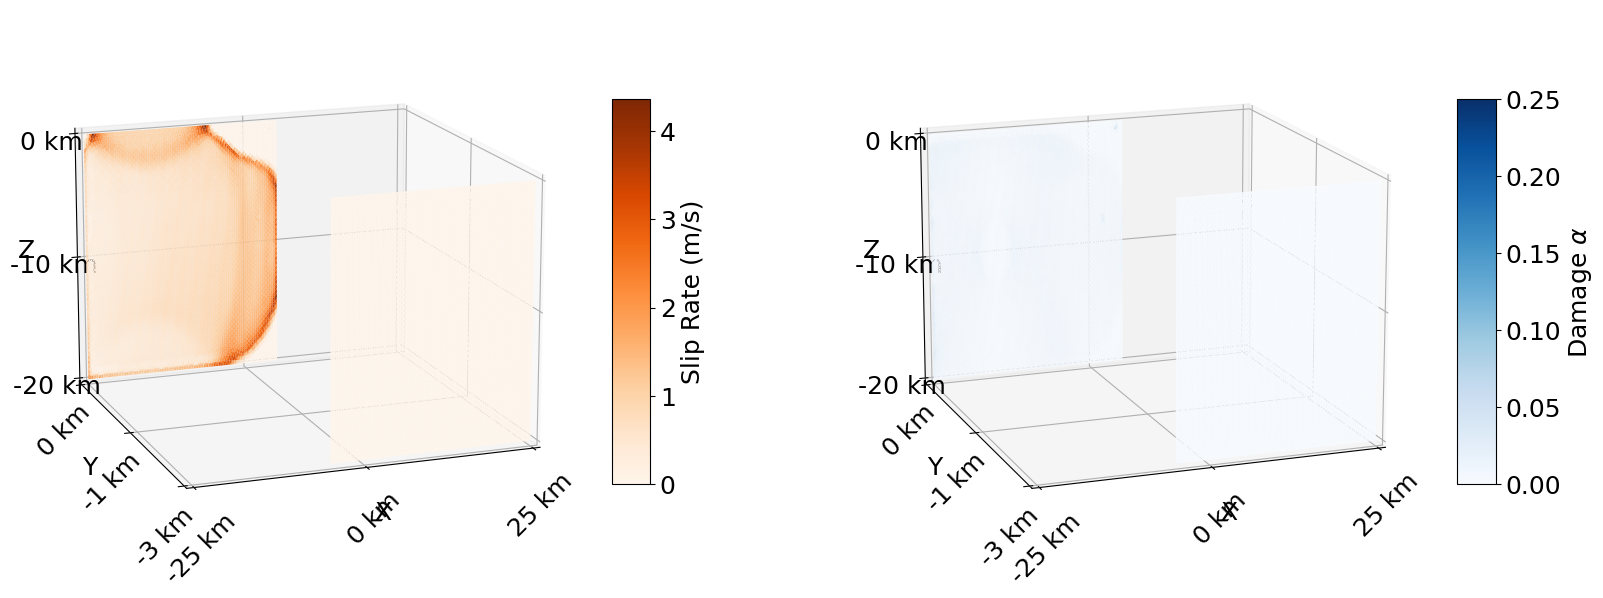

In [26]:
# Extract vertices for each triangular face in the mesh
triangles = [xyz[connect[i]] for i in range(connect.shape[0])]

# Prepare data for the triangles
verts = [tri for tri in triangles]
sRate_colors = [plt.cm.Oranges(sRate_norm(np.mean(sRate[i]))) for i in range(len(verts))]
damage_colors = [plt.cm.Blues(damage_norm(np.mean(damage[i]))) for i in range(len(verts))]

# Create subplots
fig = plt.figure(figsize=(20, 10))

x_ticks = np.linspace(np.min(xyz[:, 0]), np.max(xyz[:, 0]), 3)
y_ticks = np.linspace(np.min(xyz[:, 1]), np.max(xyz[:, 1]), 3)
z_ticks = np.linspace(np.min(xyz[:, 2]), np.max(xyz[:, 2]), 3)

# First subplot: Slip Rate
ax1 = fig.add_subplot(121, projection='3d')
sRate_collection = Poly3DCollection(verts, alpha=1.0, facecolor=sRate_colors)
ax1.add_collection3d(sRate_collection)
ax1.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax1.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax1.set_zlim(-20e3, 0)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_zticks(z_ticks)
ax1.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax1.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax1.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])

sm1 = plt.cm.ScalarMappable(cmap='Oranges', norm=sRate_norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('Slip Rate (m/s)')

# Second subplot: Damage
ax2 = fig.add_subplot(122, projection='3d')
damage_collection = Poly3DCollection(verts, alpha=1.0, facecolor=damage_colors)
ax2.add_collection3d(damage_collection)
ax2.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax2.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax2.set_zlim(-20e3, 0)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_zticks(z_ticks)
ax2.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax2.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax2.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])

sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=damage_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('Damage $\\alpha$')

# Adjust view angles
ax1.view_init(elev=15, azim=250)
ax2.view_init(elev=15, azim=250)

#plt.tight_layout()
plt.show()


The left pannel above shows the distribution of slip rate at 6 s. It shows the rupture front (high slip rate regions in darker red) has already reached the edge of the **fault 1** (the fault plane at the back). 

At the same time, the **off-fault damage** is still close to zero on **fault 2** (the fault plane at the front).

It takes some longer time for the damage zone to extend to **fault 2**. At the end of the simulation (14 s), we can see the rupture also spontaneously grow on **fault 2**. We show the results in the follow cell.

In [5]:
from mpl_toolkits import mplot3d

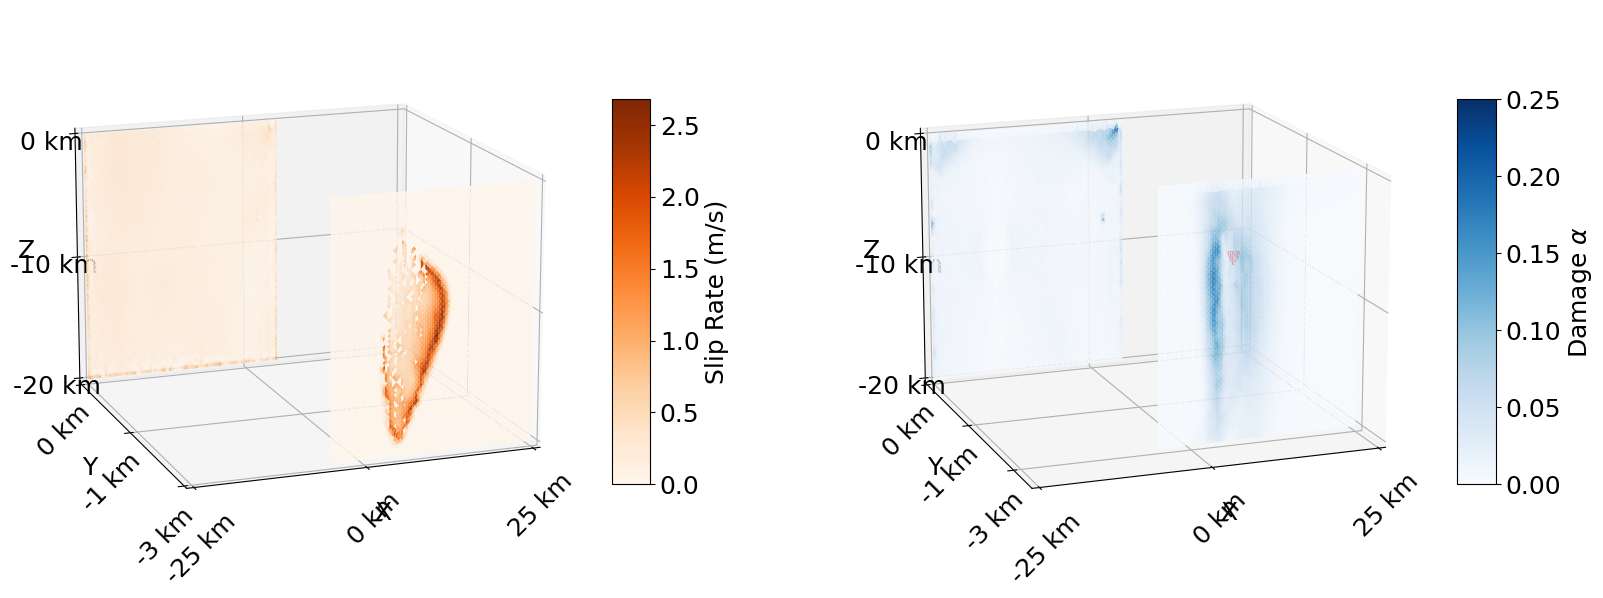

In [14]:
ndt = sx.ReadNdt()-1
sRate = sx.ReadData('SRs', ndt)
damage = sx.ReadData('u_n', ndt)

# Define the colormap ranges
sRate_vmin, sRate_vmax = np.min(sRate), np.max(sRate)
sRate_norm = mcolors.Normalize(vmin=sRate_vmin, vmax=sRate_vmax)

damage_vmin, damage_vmax = 0, 0.25
damage_norm = mcolors.Normalize(vmin=damage_vmin, vmax=damage_vmax)

# Extract vertices for each triangular face in the mesh
triangles = [xyz[connect[i]] for i in range(connect.shape[0])]

# Prepare data for the triangles
verts = [tri for tri in triangles]
sRate_colors = [plt.cm.Oranges(sRate_norm(np.mean(sRate[i]))) for i in range(len(verts))]
damage_colors = [plt.cm.Blues(damage_norm(np.mean(damage[i]))) for i in range(len(verts))]

# Create subplots
fig = plt.figure(figsize=(20, 10))

x_ticks = np.linspace(np.min(xyz[:, 0]), np.max(xyz[:, 0]), 3)
y_ticks = np.linspace(np.min(xyz[:, 1]), np.max(xyz[:, 1]), 3)
z_ticks = np.linspace(np.min(xyz[:, 2]), np.max(xyz[:, 2]), 3)

# First subplot: Slip Rate
ax1 = fig.add_subplot(121, projection='3d')
sRate_collection = Poly3DCollection(verts, alpha=1.0, facecolor=sRate_colors)
ax1.add_collection3d(sRate_collection)
ax1.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax1.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax1.set_zlim(-20e3, 0)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_zticks(z_ticks)
ax1.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax1.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax1.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])

sm1 = plt.cm.ScalarMappable(cmap='Oranges', norm=sRate_norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('Slip Rate (m/s)')

# Second subplot: Damage
ax2 = fig.add_subplot(122, projection='3d')
damage_collection = Poly3DCollection(verts, alpha=1.0, facecolor=damage_colors)
ax2.add_collection3d(damage_collection)
ax2.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax2.set_ylim(np.min(xyz[:, 1])-0.5e3, np.max(xyz[:, 1]))
ax2.set_zlim(-20e3, 0)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_zticks(z_ticks)
ax2.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax2.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax2.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])

ax2.scatter3D(5e3, -3.2e3, -5.5e3, marker='v', s=100, color='r', alpha=1.0)

sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=damage_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('Damage $\\alpha$')

# Adjust view angles
ax1.view_init(elev=15, azim=250)
ax2.view_init(elev=15, azim=250)

#plt.tight_layout()
plt.show()

From the left panel, we see the rupture front on **fault 2** now. 

This is a result of the damage zone reaching **fault 2**. We can tell the distribution of the **damage variable $\alpha$** on the **fault 2** from the right panel.

The solution at the nucleation region is not very smooth. This is a result of the low-resolution model that we run in the example to reduce the amount of time that we have to wait.

### Shear traction and strength evolution on the fault

You may now wonder why **fault 2** can be ruptured with the accumulation of damage. In the following part, we will show how the shear traction and shear strength (frictional strength) on **fault 2** evolves in time.

For this purpose, we need point-wise output on the fault fr a clearer quantitative visualization.

To read from the fault receiver files, we will need `pandas` to systematically read in different fields of data.

In [2]:
## Additional standard python library to access file names inside a folder
import os
import re

import pandas as pd

In [3]:
# Function to find the complete name of a receiver file for a given receiver {number}
def find_receiver(directory, prefix, number):
    receiver_re = re.compile(f"{prefix}-faultreceiver-{number:05d}-(\\d)+.dat")
    for fn in os.listdir(directory):
        if receiver_re.match(fn):
            print(os.path.join(directory, fn))
            return os.path.join(directory, fn)
# Function to read in time series with pandas once we know the specific receiver {file name}
def read_receiver(filename):
    with open(filename) as receiver_file:
        receiver_file.readline()
        quantity_line = receiver_file.readline().strip()
        header_length = 2
        while receiver_file.readline()[0] == "#":
            header_length += 1
    quantity_line = quantity_line.replace('"', '')
    quantities = quantity_line[12:].split(" ,")
    receiver_df = pd.read_csv(filename, skiprows=header_length, header=None, sep="\\s+")
    receiver_df.columns = quantities
    return receiver_df

Now let's plot the time series for shear traction and shear strength at a point on **fault 2** that locates inside the nucleation area.

The point receiver number is **9**, located at $x$ = 5 km, $y$ = -3 km and $z$ = 5.5 km. 

The location of th fault can be found inside the input file `tpv23_3km_faultreceivers`.

output_cdb/cdb_1401CFL1p0_tpv23-faultreceiver-00009-00000.dat
Index(['Time', 'SRs', 'SRd', 'T_s', 'T_d', 'P_n', 'u_n', 'Mud', 'StV'], dtype='object')
output_cdb/cdb_1401CFL1p0_tpv23-faultreceiver-00009-00000.dat


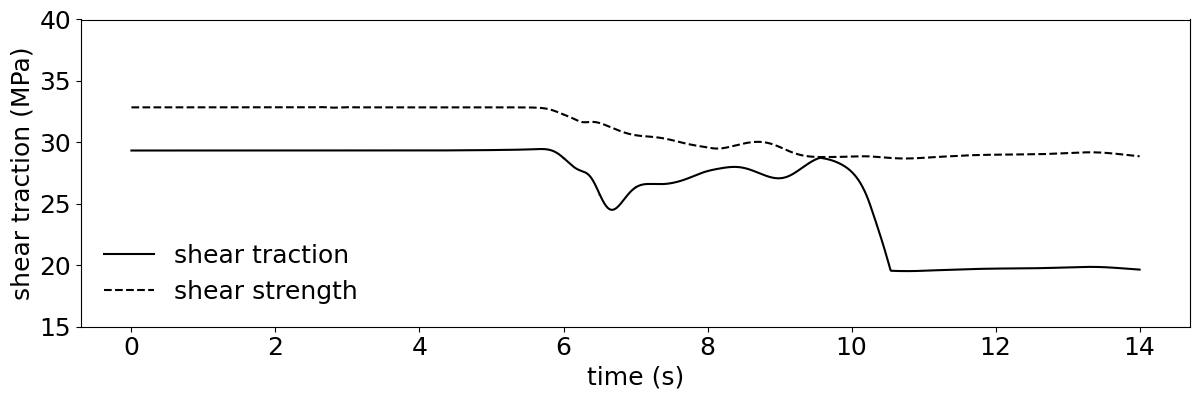

In [6]:
# Define the receiver number(s) that you want to plot
n_recs = [9]

# The output directory where the fault receiver files are stored
dirName = result_dir + 'outputs/'
# dirName = "output_cdb/"
prefi = "cdb_tpv23"

# Initialize the figure
fig, ax = plt.subplots(1,1,figsize=[12,4])

# The physical field that you would like to plot
# Here, we want to check the shear traction to determine whether the fault is triggered
comp = "T_s"

i_incre = 0
for i_r in n_recs:
    fiName = find_receiver(dirName,prefi,i_r)
    rec_fault = read_receiver(fiName)
    if i_incre == 0: print(rec_fault.columns)
    plt.plot(rec_fault["Time"],rec_fault[comp]/1e6,color='k', label=f'shear traction')
    i_incre +=1

# Switch to normal stress, which determines the shear strength 
# after multiplying with static friction \mu_s=0.548 in this example
comp = "P_n"

for i_r in n_recs:
    fiName = find_receiver(dirName,prefi,i_r)
    rec_fault = read_receiver(fiName)
    plt.plot(rec_fault["Time"],-0.548*rec_fault[comp]/1e6,"--",color='k', label=f'shear strength')

plt.xlabel('time (s)')
ax.tick_params('x')
plt.ylabel('shear traction (MPa)')
ax.tick_params('y')
plt.legend(loc='lower left',frameon=False)
plt.ylim([15,40])
plt.grid(False)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

#plt.savefig("p_shearTrac.pdf")

From the figure above, we can define **4 phases** in the evolution of **fault 2**

- Phase 1: From 0 to 5 s, the stress wave from the rupturing of **fault 1** does not yet reach **fault 2**.
- Phase 2: From 5 to 8 s, the stress wave reaches **fault 2**, but the dynamic stress field is not contributing to a larger *shear traction* (the solid curve) that can exceed *shear strength* (the dashed curve).
- Phase 3: From 8 to 9.5 s, as the damage zone reaches **fault 2** and the *shear traction* starts to increase, getting closer to *shear strength*.
- Phase 4: After 9.5 s, **fault 2** rupture spontaneously and the *shear stress* drops again.

More details will be soon available in our publication that is soon to be submitted. Please stay tuned :)